In [2]:
# 1_load_data.py (fixed)
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,4)

OUT_DIR = "spotify_results"
os.makedirs(OUT_DIR, exist_ok=True)
TRACKS_CSV = "spotify_tracks.csv"
DESC_CSV = "spotify_data_description.csv"

# ✅ FIXED: skip malformed lines safely
df = pd.read_csv(TRACKS_CSV, low_memory=False, on_bad_lines='skip')
desc = pd.read_csv(DESC_CSV, low_memory=False) if os.path.exists(DESC_CSV) else None

if 'duration_ms' in df.columns:
    df['duration_min'] = df['duration_ms'] / 60000.0
date_cols = [c for c in df.columns if 'date' in c.lower()]
if date_cols:
    df[date_cols[0]] = pd.to_datetime(df[date_cols[0]], errors='coerce')
    df['year'] = df[date_cols[0]].dt.year

print("Loaded tracks:", df.shape)
print("Columns:", list(df.columns))
df.head(3)



Loaded tracks: (12691, 23)
Columns: ['track_id', 'track_name', 'artist_name', 'year', 'popularity', 'artwork_url', 'album_name', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'track_url', 'language', 'duration_min']


,track_id,track_name,artist_name,year,popularity,artwork_url,album_name,acousticness,danceability,duration_ms,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_url,language,duration_min
0,2r0ROhr7pRN4MXDMT1fEmd,"Leo Das Entry (From ""Leo"")",Anirudh Ravichander,2024,59,https://i.scdn.co/image/ab67616d0000b273ce9c65...,"Leo Das Entry (From ""Leo"")",0.0241,0.753,97297.0,...,0.1000,-5.994,0.0,0.1030,110.997,4.0,0.459,https://open.spotify.com/track/2r0ROhr7pRN4MXD...,Tamil,1.621617
1,4I38e6Dg52a2o2a8i5Q5PW,AAO KILLELLE,"Anirudh Ravichander, Pravin Mani, Vaishali Sri...",2024,47,https://i.scdn.co/image/ab67616d0000b273be1b03...,AAO KILLELLE,0.0851,0.780,207369.0,...,0.0951,-5.674,0.0,0.0952,164.995,3.0,0.821,https://open.spotify.com/track/4I38e6Dg52a2o2a...,Tamil,3.456150
2,59NoiRhnom3lTeRFaBzOev,Mayakiriye Sirikiriye - Orchestral EDM,"Anirudh Ravichander, Anivee, Alvin Bruno",2024,35,https://i.scdn.co/image/ab67616d0000b27334a1dd...,Mayakiriye Sirikiriye (Orchestral EDM),0.0311,0.457,82551.0,...,0.0831,-8.937,0.0,0.1530,169.996,4.0,0.598,https://open.spotify.com/track/59NoiRhnom3lTeR...,Tamil,1.375850


In [3]:
# =====================  Univariate Analysis (Clean + Safe) =====================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

OUT_DIR = "spotify_results"
os.makedirs(OUT_DIR, exist_ok=True)

#  Clean all numeric columns first
numeric_candidates = [
    'popularity','duration_ms','duration_min','tempo','acousticness','loudness',
    'danceability','energy','speechiness','instrumentalness','valence','mode',
    'key','time_signature'
]
for col in numeric_candidates:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

#  Robust helper function (auto-converts to numeric, ignores bad data)
def hist_and_stats(series, colname, bins=30, xlabel=None, out_dir=OUT_DIR):
    arr = pd.to_numeric(series, errors='coerce').dropna()
    if arr.empty:
        print(f"⚠️ Skipping {colname}: no valid numeric values.")
        return {}

    stats = {
        "count": int(arr.count()),
        "mean": float(arr.mean()),
        "median": float(arr.median()),
        "std": float(arr.std()),
        "min": float(arr.min()),
        "25%": float(arr.quantile(0.25)),
        "75%": float(arr.quantile(0.75)),
        "max": float(arr.max())
    }

    # Plot histogram
    fig = plt.figure(figsize=(8,4))
    plt.hist(arr, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {colname}")
    if xlabel: plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle=':', linewidth=0.5)
    fig.savefig(f"{out_dir}/{colname}_hist.png", bbox_inches='tight')
    plt.close(fig)

    return stats


#  Columns to analyze
features = [
    ('popularity','popularity (0–100)'),
    ('duration_min','duration (minutes)'),
    ('tempo','tempo (BPM)'),
    ('acousticness','acousticness (0–1)'),
    ('loudness','loudness (dB)'),
    ('danceability','danceability (0–1)'),
    ('energy','energy (0–1)'),
    ('speechiness','speechiness (0–1)'),
    ('instrumentalness','instrumentalness (0–1)'),
    ('valence','valence (0–1)')
]

# Run analysis
uni_summary = {}
for col, xlabel in features:
    if col in df.columns:
        uni_summary[col] = hist_and_stats(df[col], col, bins=30, xlabel=xlabel)

#  Handle categorical columns separately
if 'key' in df.columns:
    key_counts = df['key'].value_counts().sort_index()
    key_counts.to_csv(f"{OUT_DIR}/key_counts.csv")
    fig = plt.figure(figsize=(8,4))
    plt.bar(key_counts.index.astype(str), key_counts.values, color='lightgreen', edgecolor='black')
    plt.title("Key Distribution (numeric coding)")
    plt.xlabel("Key"); plt.ylabel("Count")
    plt.grid(axis='y', linestyle=':', linewidth=0.5)
    fig.savefig(f"{OUT_DIR}/key_counts.png", bbox_inches='tight')
    plt.close(fig)
    uni_summary['key_counts'] = key_counts.to_dict()

if 'time_signature' in df.columns:
    ts = df['time_signature'].value_counts().sort_index()
    ts.to_csv(f"{OUT_DIR}/time_signature_counts.csv")
    fig = plt.figure(figsize=(8,4))
    plt.bar(ts.index.astype(str), ts.values, color='salmon', edgecolor='black')
    plt.title("Time Signature Distribution")
    plt.xlabel("Time Signature"); plt.ylabel("Count")
    plt.grid(axis='y', linestyle=':', linewidth=0.5)
    fig.savefig(f"{OUT_DIR}/time_signature_counts.png", bbox_inches='tight')
    plt.close(fig)
    uni_summary['time_signature'] = ts.to_dict()

#  Save summary statistics
with open(f"{OUT_DIR}/univariate_summary.json", "w") as f:
    json.dump(uni_summary, f, indent=2)

print(" Univariate analysis complete.")
print(f"All histograms & summary files saved inside: {OUT_DIR}")
pd.DataFrame(uni_summary).T



 Univariate analysis complete.
All histograms & summary files saved inside: spotify_results


,count,mean,median,std,min,25%,75%,max,-1.0,0.0,...,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
popularity,12691.0,15.903002,9.000000,17.627173,0.000000,1.000000,27.00000,83.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration_min,12691.0,4.175078,4.266450,1.992550,0.189333,3.372983,5.03225,67.538533,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tempo,12691.0,117.999062,116.352000,28.464377,-1.000000,95.041500,135.96600,239.970000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acousticness,12691.0,0.376549,0.330000,0.282258,-1.000000,0.123000,0.61000,0.995000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loudness,12691.0,-39.928214,-7.663000,1774.987087,-100000.000000,-10.034000,-5.87650,0.894000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
danceability,12691.0,0.625725,0.647000,0.169490,-1.000000,0.523000,0.74800,0.986000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
energy,12691.0,0.622934,0.643000,0.212715,-1.000000,0.471000,0.79700,0.999000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
speechiness,12691.0,0.085718,0.050200,0.088629,-1.000000,0.035800,0.09635,0.944000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
instrumentalness,12691.0,0.095860,0.000051,0.249403,-1.000000,0.000000,0.00466,0.991000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
valence,12691.0,0.523923,0.534000,0.248905,-1.000000,0.330000,0.72900,0.982000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# 3_bivariate.py (Cell 3)
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import json

pairs = [
    ('duration_min','popularity'),
    ('danceability','popularity'),
    ('energy','popularity'),
    ('loudness','popularity'),
    ('acousticness','popularity')
]

bivar_results = {}
for x, y in pairs:
    if x in df.columns and y in df.columns:
        sub = df[[x,y]].dropna()
        if len(sub) < 5:
            bivar_results[f"{x}__{y}"] = None
            continue
        r, p = pearsonr(sub[x], sub[y])
        bivar_results[f"{x}__{y}"] = {"r": float(r), "p": float(p), "n": int(len(sub))}
        # scatter plot + regression
        fig = plt.figure()
        plt.scatter(sub[x], sub[y], s=8, alpha=0.5)
        try:
            coef = np.polyfit(sub[x], sub[y], 1)
            plt.plot(sub[x], np.polyval(coef, sub[x]), linewidth=1, color='k')
        except Exception:
            pass
        plt.xlabel(x); plt.ylabel(y)
        plt.title(f"{y} vs {x} (r={r:.3f})")
        fig.savefig(f"{OUT_DIR}/scatter_{x}_vs_{y}.png", bbox_inches='tight')
        plt.close(fig)

# Save
import json
with open(f"{OUT_DIR}/bivariate_results.json", "w") as f:
    json.dump(bivar_results, f, indent=2)
print("Bivariate results saved to", OUT_DIR)
bivar_results


Bivariate results saved to spotify_results


{'duration_min__popularity': {'r': -0.04200578193394505,
  'p': 2.181382784465978e-47,
  'n': 118391},
 'danceability__popularity': {'r': 0.04161475624912735,
  'p': 1.5304413968578651e-46,
  'n': 118391},
 'energy__popularity': {'r': 0.14813232641134688, 'p': 0.0, 'n': 118390},
 'loudness__popularity': {'r': 0.013004416761852305,
  'p': 7.652515696198546e-06,
  'n': 118390},
 'acousticness__popularity': {'r': -0.0024773648894209515,
  'p': 0.3939899829477436,
  'n': 118391}}

In [8]:
# 4_multivariate_clustering.py (Cell 4)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import json

multi_results = {}
if 'popularity' in df.columns:
    q75 = df['popularity'].quantile(0.75)
    topq = df[df['popularity'] >= q75].copy()
    multi_results['topq_count'] = int(len(topq))
    comb_cols = [c for c in ['danceability','energy','valence'] if c in topq.columns]
    if comb_cols:
        comb_desc = topq[comb_cols].describe().T
        comb_desc.to_csv(f"{OUT_DIR}/topq_combination_stats.csv")
        multi_results['topq_comb_stats'] = comb_desc.to_dict()
    # Clustering
    cl_cols = [c for c in ['acousticness','instrumentalness','speechiness'] if c in topq.columns]
    if len(cl_cols) >= 2 and len(topq) >= 10:
        sample = topq[cl_cols].dropna().sample(min(2000, len(topq)), random_state=1)
        scaler = StandardScaler()
        Xs = scaler.fit_transform(sample.values)
        # elbow inertias (optional)
        inertias = {}
        for k in range(2,6):
            km = KMeans(n_clusters=k, random_state=1, n_init=10)
            km.fit(Xs)
            inertias[k] = float(km.inertia_)
        # choose k=3 (default) — you can change after inspecting inertias
        k = 3 if len(sample) >= 3 else 2
        km = KMeans(n_clusters=k, random_state=1, n_init=10).fit(Xs)
        centers = scaler.inverse_transform(km.cluster_centers_)
        centers_df = pd.DataFrame(centers, columns=cl_cols)
        centers_df['size'] = np.bincount(km.labels_)
        centers_df.to_csv(f"{OUT_DIR}/cluster_centers_topq.csv", index=False)
        multi_results['clusters'] = {'k': k, 'centers': centers_df.to_dict(orient='list'), 'inertias': inertias}
    # popular mix recipe (loudness, tempo, mode)
    recipe_cols = [c for c in ['loudness','tempo','mode'] if c in topq.columns]
    if recipe_cols:
        recipe_stats = topq[recipe_cols].agg(['mean','median','std','count']).T
        recipe_stats.to_csv(f"{OUT_DIR}/popular_mix_recipe_topq.csv")
        multi_results['popular_mix_recipe'] = recipe_stats.to_dict()
else:
    print("No popularity column found; skipping multivariate analysis.")

with open(f"{OUT_DIR}/multivariate_summary.json", "w") as f:
    json.dump(multi_results, f, indent=2, default=str)

print("Multivariate results saved to", OUT_DIR)
multi_results


Multivariate results saved to spotify_results


{'topq_count': 30168,
 'topq_comb_stats': {'count': {'danceability': 30168.0,
   'energy': 30168.0,
   'valence': 30167.0},
  'mean': {'danceability': 0.6096410766374968,
   'energy': 0.6572933538849111,
   'valence': 0.5015761328604104},
  'std': {'danceability': 0.16596982246071657,
   'energy': 0.21964801536768477,
   'valence': 0.24309941346797007},
  'min': {'danceability': -1.0, 'energy': -1.0, 'valence': -1.0},
  '25%': {'danceability': 0.522, 'energy': 0.52, 'valence': 0.319},
  '50%': {'danceability': 0.633, 'energy': 0.698, 'valence': 0.507},
  '75%': {'danceability': 0.727, 'energy': 0.835, 'valence': 0.694},
  'max': {'danceability': 0.973, 'energy': 0.998, 'valence': 0.989}},
 'clusters': {'k': 3,
  'centers': {'acousticness': [0.12060997107393007,
    0.450847715582822,
    0.6583297101449275],
   'instrumentalness': [0.006330405758754612,
    0.8183312883435586,
    0.010734823115941997],
   'speechiness': [0.09408249027237353,
    0.05681717791411043,
    0.056757246376

In [9]:
# 5_time_series.py (Cell 5)
import matplotlib.pyplot as plt
import json

time_results = {}
if 'year' in df.columns and df['year'].notnull().sum() > 0:
    yearly_pop = df.groupby('year')['popularity'].mean().dropna().sort_index()
    yearly_pop.to_csv(f"{OUT_DIR}/yearly_popularity_mean.csv")
    # plot and save
    fig = plt.figure()
    plt.plot(yearly_pop.index, yearly_pop.values, marker='o')
    plt.title("Average popularity by year")
    plt.xlabel("year"); plt.ylabel("avg popularity")
    plt.grid(True, linestyle=':', linewidth=0.5)
    fig.savefig(f"{OUT_DIR}/yearly_popularity.png", bbox_inches='tight')
    plt.close(fig)
    time_results['yearly_popularity_mean'] = yearly_pop.to_dict()
    # Top-quartile danceability & energy
    if 'danceability' in df.columns and 'energy' in df.columns and 'popularity' in df.columns:
        q75 = df['popularity'].quantile(0.75)
        topq = df[df['popularity'] >= q75]
        yearly_top = topq.groupby('year')[['danceability','energy']].mean().dropna().sort_index()
        yearly_top.to_csv(f"{OUT_DIR}/yearly_top_dance_energy.csv")
        fig = plt.figure()
        plt.plot(yearly_top.index, yearly_top['danceability'], marker='o', label='danceability')
        plt.plot(yearly_top.index, yearly_top['energy'], marker='o', label='energy')
        plt.legend(); plt.title("Top-quartile: danceability & energy by year")
        fig.savefig(f"{OUT_DIR}/yearly_top_dance_energy.png", bbox_inches='tight')
        plt.close(fig)
        time_results['yearly_top_dance_energy'] = yearly_top.reset_index().to_dict(orient='list')
else:
    print("No 'year' column available — skip time-series.")

with open(f"{OUT_DIR}/time_series_summary.json", "w") as f:
    json.dump(time_results, f, indent=2, default=str)

print("Time-series results saved to", OUT_DIR)
time_results


Time-series results saved to spotify_results


{'yearly_popularity_mean': {'0.131': -3.685,
  '0.858': 0.571,
  '1971': 30.666666666666668,
  '1972': 26.80952380952381,
  '1973': 27.06451612903226,
  '1974': 31.0,
  '1975': 37.36842105263158,
  '1976': 39.333333333333336,
  '1977': 34.46153846153846,
  '1978': 30.571428571428573,
  '1979': 31.608695652173914,
  '1980': 24.55,
  '1981': 14.135135135135135,
  '1982': 12.560975609756097,
  '1983': 12.625,
  '1984': 8.699530516431924,
  '1985': 12.6640625,
  '1986': 11.111753371868978,
  '1987': 13.766666666666667,
  '1988': 8.421739130434782,
  '1989': 12.198653198653199,
  '1990': 9.947115384615385,
  '1991': 10.347014925373134,
  '1992': 7.901234567901234,
  '1993': 8.057377049180328,
  '1994': 10.367816091954023,
  '1995': 11.859956236323852,
  '1996': 12.555555555555555,
  '1997': 11.225609756097562,
  '1998': 14.04513888888889,
  '1999': 12.880782918149466,
  '2000': 21.467654986522913,
  '2001': 19.4181626187962,
  '2002': 14.874476987447698,
  '2003': 14.795376712328768,
  '200

In [1]:
# ======== FAST VERSION: Modeling baseline (RandomForest, optimized) ========
import os, json, joblib
import numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ✅ Ensure dataset is loaded
if "df" not in globals():
    TRACKS_CSV = "spotify_tracks.csv"
    print("Reloading dataset quickly...")
    df = pd.read_csv(TRACKS_CSV, low_memory=False, on_bad_lines='skip')
    if "duration_ms" in df.columns:
        df["duration_min"] = df["duration_ms"] / 60000.0
    print("✅ Dataset loaded:", df.shape)

OUT_DIR = "spotify_results"
os.makedirs(OUT_DIR, exist_ok=True)

# ==================== TRAIN LIGHT RANDOM FOREST ====================
features = [c for c in [
    'danceability','energy','loudness','speechiness','acousticness',
    'instrumentalness','valence','tempo','duration_min'
] if c in df.columns]
target = 'popularity'

# Clean numeric
df_model = df[features + [target]].apply(pd.to_numeric, errors='coerce').dropna()
print(f"Rows available for modeling: {len(df_model)}")

if len(df_model) < 50:
    raise ValueError("Not enough valid rows for modeling.")

X = df_model[features].values
y = df_model[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# ⚡ Lighter RF: 100 trees, no CV
rf = RandomForestRegressor(n_estimators=100, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions & quick metrics
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n✅ MODEL RESULTS:\nR² (test) = {r2:.3f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}")

# Feature importance
feat_imp = pd.DataFrame({
    "feature": features,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

# Save outputs
model_path = os.path.join(OUT_DIR, "rf_popularity_model_fast.joblib")
joblib.dump(rf, model_path)
feat_imp.to_csv(os.path.join(OUT_DIR, "feature_importances_fast.csv"), index=False)

# True vs predicted plot
fig = plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, s=12, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", linewidth=1)
plt.xlabel("True popularity")
plt.ylabel("Predicted popularity")
plt.title("Random Forest: True vs Predicted")
plt.grid(True, linestyle=':', linewidth=0.5)
fig.savefig(os.path.join(OUT_DIR, "rf_true_vs_pred_fast.png"), bbox_inches='tight')
plt.close(fig)

# Summary dict
model_results = {
    "rows_used": len(df_model),
    "features": features,
    "r2_test": float(r2),
    "mae_test": float(mae),
    "rmse_test": float(rmse),
    "model_path": model_path,
    "feature_importances_path": f"{OUT_DIR}/feature_importances_fast.csv"
}

# Save summary
with open(os.path.join(OUT_DIR, "model_summary_fast.json"), "w") as f:
    json.dump(model_results, f, indent=2)

print("\nAll outputs saved in:", OUT_DIR)
print("\nTop 5 Feature Importances:\n", feat_imp.head())
model_results




Reloading dataset quickly...
✅ Dataset loaded: (118395, 23)
Rows available for modeling: 118387

✅ MODEL RESULTS:
R² (test) = 0.629
MAE = 7.387
RMSE = 11.307

All outputs saved in: spotify_results

Top 5 Feature Importances:
         feature  importance
2      loudness    0.162084
8  duration_min    0.132222
4  acousticness    0.116404
7         tempo    0.106444
6       valence    0.105722


{'rows_used': 118387,
 'features': ['danceability',
  'energy',
  'loudness',
  'speechiness',
  'acousticness',
  'instrumentalness',
  'valence',
  'tempo',
  'duration_min'],
 'r2_test': 0.6294207481643869,
 'mae_test': 7.386902375956895,
 'rmse_test': 11.30667303795727,
 'model_path': 'spotify_results/rf_popularity_model_fast.joblib',
 'feature_importances_path': 'spotify_results/feature_importances_fast.csv'}

In [2]:
# 7_save_summary.py (Cell 7)
import json, os, glob

summary = {}
paths = glob.glob(f"{OUT_DIR}/*")
for p in paths:
    name = os.path.basename(p)
    summary[name] = p

with open(f"{OUT_DIR}/_files_index.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Indexed generated files in", OUT_DIR)


Indexed generated files in spotify_results


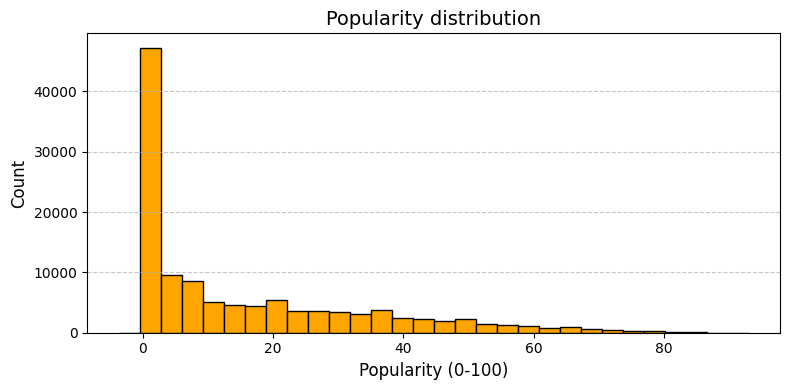


--- Popularity Statistics (Cleaned) ---
count    118390.000000
mean         15.224473
std          18.628733
min          -3.685000
25%           0.000000
50%           7.000000
75%          26.000000
max          93.000000
Name: popularity, dtype: float64
Skewness: 1.253
Kurtosis: 0.729


In [16]:
 # ==============================================
# POPULARITY DISTRIBUTION ANALYSIS (CLEAN VERSION)
# ==============================================

import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Load dataset safely
df = pd.read_csv("spotify_tracks.csv", on_bad_lines="skip", engine="python")

# 2. Convert 'popularity' to numeric, forcing errors to NaN (for any URLs/text)
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')

# 3. Drop missing or invalid popularity values
df = df.dropna(subset=['popularity'])

# 4. Extract cleaned popularity column
popularity = df['popularity']

# 5. Create output folder
os.makedirs("spotify_outputs", exist_ok=True)

# 6. Plot histogram
plt.figure(figsize=(8,4))
plt.hist(popularity, bins=30, color='orange', edgecolor='black')
plt.title("Popularity distribution", fontsize=14)
plt.xlabel("Popularity (0-100)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 7. Save and show the plot
plt.savefig("spotify_outputs/popularity_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# 8. Print numeric summary
print("\n--- Popularity Statistics (Cleaned) ---")
print(popularity.describe())
print("Skewness:", round(popularity.skew(), 3))
print("Kurtosis:", round(popularity.kurtosis(), 3))



--- Key Frequency Counts ---
key
-8.670         1
-5.571         1
-1.000        66
 0.000     15447
 0.390         1
 1.000     10899
 2.000     13023
 3.000      3085
 4.000      9338
 5.000     12157
 6.000      6998
 7.000     13269
 8.000      7103
 9.000     11217
 10.000     7269
 11.000     8516
Name: count, dtype: int64


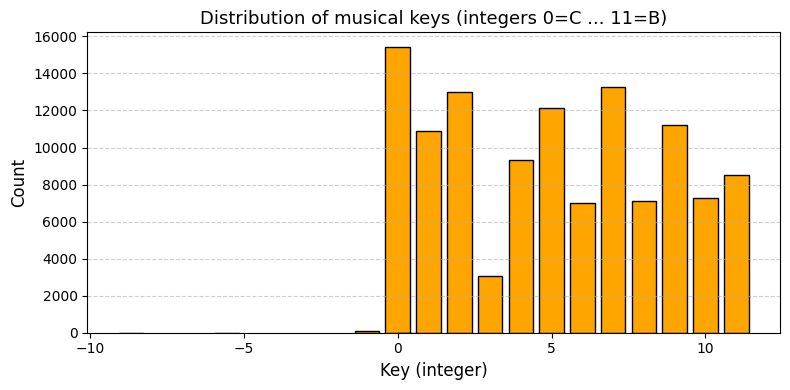

In [17]:
# ==============================================
# DISTRIBUTION OF MUSICAL KEYS (SPOTIFY DATA)
# ==============================================

import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Load dataset safely
df = pd.read_csv("spotify_tracks.csv", on_bad_lines="skip", engine="python")

# 2. Convert 'key' column to numeric (handles stray text)
df['key'] = pd.to_numeric(df['key'], errors='coerce')

# 3. Drop rows where key is missing
df = df.dropna(subset=['key'])

# 4. Count occurrences of each key
key_counts = df['key'].value_counts().sort_index()

# 5. Display top few for verification
print("\n--- Key Frequency Counts ---")
print(key_counts)

# 6. Create output folder
os.makedirs("spotify_outputs", exist_ok=True)

# 7. Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(key_counts.index, key_counts.values, color='orange', edgecolor='black')
plt.title("Distribution of musical keys (integers 0=C ... 11=B)", fontsize=13)
plt.xlabel("Key (integer)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 8. Save and show
plt.savefig("spotify_outputs/key_distribution.png", dpi=300, bbox_inches="tight")
plt.show()



--- Energy Statistics ---
count    118390.000000
mean          0.599301
std           0.247822
min          -1.000000
25%           0.434000
50%           0.635000
75%           0.801000
max           2.000000
Name: energy, dtype: float64


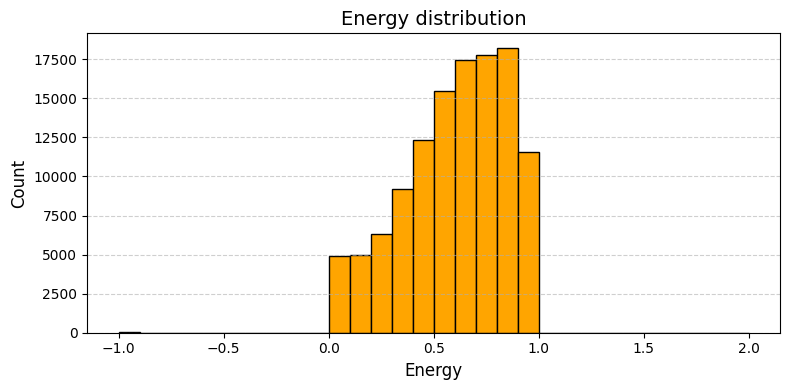

In [19]:
# ==============================================
# ENERGY DISTRIBUTION (SPOTIFY DATA)
# ==============================================

import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Load dataset safely
df = pd.read_csv("spotify_tracks.csv", on_bad_lines="skip", engine="python")

# 2. Convert 'energy' column to numeric (handle bad data)
df['energy'] = pd.to_numeric(df['energy'], errors='coerce')

# 3. Drop missing/invalid values
df = df.dropna(subset=['energy'])

# 4. Extract column
energy = df['energy']

# 5. Print summary statistics
print("\n--- Energy Statistics ---")
print(energy.describe())

# 6. Create output folder
os.makedirs("spotify_outputs", exist_ok=True)

# 7. Plot histogram
plt.figure(figsize=(8,4))
plt.hist(energy, bins=30, color='orange', edgecolor='black')
plt.title("Energy distribution", fontsize=14)
plt.xlabel("Energy", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 8. Save & show
plt.savefig("spotify_outputs/energy_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


In [23]:
# -----------------------------------------------------------------------------
# Deep EDA & Research Pipeline for Spotify Tracks (comprehensive)
# - robust reading & cleaning
# - univariate + bivariate analyses
# - correlations & stats tests
# - time-series trends by year
# - top-decile "popular" profiling + RandomForest feature importance
# - clustering of sound-profiles
# - saves images and CSV summaries
#
# Requirements:
#   pip install pandas numpy matplotlib seaborn scikit-learn scipy joblib
#
# Usage:
#   Place spotify_tracks.csv in same folder, then run this notebook/script.
# -----------------------------------------------------------------------------

import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib

RANDOM_STATE = 42
OUTDIR = "spotify_deep_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# ---------------------
# 1) LOAD / BASIC CHECK
# ---------------------
def load_dataset(path="spotify_tracks.csv"):
    # robust load: skip malformed CSV lines, use python engine
    df = pd.read_csv(path, on_bad_lines="skip", engine="python")
    print("Loaded:", df.shape)
    return df

df = load_dataset("spotify_tracks.csv")
df.columns = [c.strip() for c in df.columns]  # trim whitespace
display(df.head(3))
print("\nData types:\n", df.dtypes.value_counts())

# ---------------------
# 2) CLEANING helpers
# ---------------------
def to_numeric_cols(df, cols):
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

# numeric audio features that should be floats/ints
numeric_cols = [
    'popularity','duration_ms','acousticness','danceability','energy',
    'loudness','speechiness','instrumentalness','tempo','valence',
    'liveness','key','mode','time_signature'
]

df = to_numeric_cols(df, [c for c in numeric_cols if c in df.columns])

# drop duplicates by track_id if present
if 'track_id' in df.columns:
    before = df.shape[0]
    df = df.drop_duplicates(subset=['track_id'])
    print(f"Dropped {before - df.shape[0]} duplicate track_id rows")

# Drop rows with no popularity (we can't analyze without it)
df = df.dropna(subset=['popularity'])
df.reset_index(drop=True, inplace=True)
print("After cleaning, rows:", df.shape[0])

# create friendly derived columns
df['duration_min'] = df['duration_ms'] / 60000.0

# ---------------------
# 3) QUICK SUMMARY STATS
# ---------------------
num = df.select_dtypes(include=[np.number])
summary = num.describe().T
summary.to_csv(os.path.join(OUTDIR, "numeric_summary.csv"))
print("Saved numeric summary ->", os.path.join(OUTDIR, "numeric_summary.csv"))

# Save top 20 popular tracks for manual inspection
if all(c in df.columns for c in ['track_name','artist_name','popularity']):
    top20 = df.sort_values('popularity', ascending=False)[['track_name','artist_name','popularity']].head(20)
    top20.to_csv(os.path.join(OUTDIR, "top20_popular_tracks.csv"), index=False)
    print("Saved top20 popular tracks ->", os.path.join(OUTDIR, "top20_popular_tracks.csv"))

# ---------------------
# 4) UNIVARIATE VISUALS (main features)
# ---------------------
def hist_save(series, title, fname, bins=30, xlabel=None):
    plt.figure(figsize=(8,4))
    plt.hist(series.dropna(), bins=bins, color='orange', edgecolor='black')
    plt.title(title)
    if xlabel: plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    path = os.path.join(OUTDIR, fname)
    plt.savefig(path, dpi=200, bbox_inches='tight')
    plt.close()
    print("Saved:", path)

# Popularity distribution
hist_save(df['popularity'], "Popularity distribution", "popularity_distribution.png", bins=40, xlabel="Popularity (0-100)")

# Duration distribution
hist_save(df['duration_min'], "Duration (minutes) distribution", "duration_minutes_distribution.png", bins=40, xlabel="Duration (minutes)")

# Tempo distribution
if 'tempo' in df.columns:
    hist_save(df['tempo'], "Tempo distribution (BPM)", "tempo_distribution.png", bins=50, xlabel="Tempo (BPM)")

# Acousticness, Danceability, Energy, Speechiness, Valence
for feat in ['acousticness','danceability','energy','speechiness','valence','instrumentalness','liveness']:
    if feat in df.columns:
        hist_save(df[feat], f"{feat.capitalize()} distribution", f"{feat}_distribution.png", bins=30, xlabel=feat)

# Key bar chart
if 'key' in df.columns:
    key_counts = df['key'].value_counts().sort_index()
    plt.figure(figsize=(8,4))
    plt.bar(key_counts.index.astype(str), key_counts.values, color='orange', edgecolor='black')
    plt.title("Distribution of musical keys (integers 0=C ... 11=B)")
    plt.xlabel("Key (integer)")
    plt.ylabel("Count")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    path = os.path.join(OUTDIR, "key_distribution.png")
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.close()
    print("Saved:", path)

# Time signature chart
if 'time_signature' in df.columns:
    ts_counts = df['time_signature'].value_counts().sort_index()
    plt.figure(figsize=(6,3))
    plt.bar(ts_counts.index.astype(str), ts_counts.values, color='orange', edgecolor='black')
    plt.title("Time signature distribution")
    plt.xlabel("Time signature")
    plt.ylabel("Count")
    plt.tight_layout()
    path = os.path.join(OUTDIR, "time_signature_distribution.png")
    plt.savefig(path, dpi=200)
    plt.close()
    print("Saved:", path)

# ---------------------
# 5) CORRELATIONS WITH POPULARITY
# ---------------------
# Choose numeric features to correlate with popularity
corr_features = ['danceability','energy','loudness','tempo','acousticness','speechiness','valence','instrumentalness','duration_min','liveness']
corr_features = [c for c in corr_features if c in df.columns]

corr_df = df[corr_features + ['popularity']].corr()
# correlation with popularity
corr_with_pop = corr_df['popularity'].drop('popularity').sort_values(ascending=False)
print("\nCorrelation with popularity:\n", corr_with_pop)
corr_df.to_csv(os.path.join(OUTDIR, "correlation_matrix.csv"))
print("Saved correlation matrix ->", os.path.join(OUTDIR, "correlation_matrix.csv"))

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "correlation_heatmap.png"), dpi=200)
plt.close()
print("Saved correlation heatmap ->", os.path.join(OUTDIR, "correlation_heatmap.png"))

# Pearson tests (r, p-value) for top correlates
from scipy.stats import pearsonr
pearson_results = []
for feat in corr_with_pop.index[:8]:  # top 8 to keep it concise
    valid = df[[feat,'popularity']].dropna()
    if valid.shape[0] > 10:
        r, p = pearsonr(valid[feat], valid['popularity'])
        pearson_results.append((feat, r, p))
pearson_df = pd.DataFrame(pearson_results, columns=['feature','pearson_r','p_value'])
pearson_df.to_csv(os.path.join(OUTDIR, "pearson_pop.csv"), index=False)
print("Saved Pearson results ->", os.path.join(OUTDIR, "pearson_pop.csv"))
display(pearson_df)

# ---------------------
# 6) POPULAR TRACK PROFILE (Top 10% & Top 25%)
# ---------------------
pop90 = df['popularity'].quantile(0.90)
pop75 = df['popularity'].quantile(0.75)
print(f"Top 10% threshold: {pop90}, Top 25% threshold: {pop75}")

top10 = df[df['popularity'] >= pop90]
top25 = df[df['popularity'] >= pop75]

def group_stats(subdf, name):
    s = subdf[corr_features].describe().T[['mean','50%','std']]
    s.rename(columns={'50%':'median'}, inplace=True)
    s.to_csv(os.path.join(OUTDIR, f"{name}_feature_stats.csv"))
    print(f"Saved {name} stats ->", os.path.join(OUTDIR, f"{name}_feature_stats.csv"))
    return s

s_top10 = group_stats(top10, "top10")
s_top25 = group_stats(top25, "top25")
s_overall = group_stats(df, "overall")

display(s_overall.head(), s_top25.head(), s_top10.head())

# ---------------------
# 7) SIMPLE CLASSIFIER: Predict HIGH_POPULAR (top10) and get feature importances
# ---------------------
# prepare feature matrix X and label y for classification
feats_for_model = [c for c in corr_features if c in df.columns]
df_model = df.dropna(subset=feats_for_model + ['popularity']).copy()
df_model['high_pop'] = (df_model['popularity'] >= pop90).astype(int)

X = df_model[feats_for_model].values
y = df_model['high_pop'].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

# scale
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
clf.fit(X_train_s, y_train)
y_pred = clf.predict(X_test_s)
y_proba = clf.predict_proba(X_test_s)[:,1]

print("Classifier accuracy:", accuracy_score(y_test, y_pred))
try:
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
except:
    pass
print(classification_report(y_test, y_pred))

# feature importance
importances = pd.Series(clf.feature_importances_, index=feats_for_model).sort_values(ascending=False)
importances.to_csv(os.path.join(OUTDIR, "rf_feature_importances_top10.csv"))
print("Saved RF feature importances ->", os.path.join(OUTDIR, "rf_feature_importances_top10.csv"))
display(importances)

# save model + scaler
joblib.dump(clf, os.path.join(OUTDIR, "rf_top10_model.joblib"))
joblib.dump(scaler, os.path.join(OUTDIR, "rf_scaler.joblib"))
print("Saved RF model and scaler in", OUTDIR)

# ---------------------
# 8) CLUSTERING: Find sound-profile groups & how they map to popularity
# ---------------------
cluster_feats = [f for f in ['acousticness','instrumentalness','speechiness','energy','danceability','valence'] if f in df.columns]
df_cluster = df.dropna(subset=cluster_feats + ['popularity']).copy()
Xc = StandardScaler().fit_transform(df_cluster[cluster_feats].values)

# choose k=3..5 and inspect inertia; we'll use k=4 by default
k = 4
km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
labels = km.fit_predict(Xc)
df_cluster['cluster'] = labels

# cluster sizes & mean popularity per cluster
cluster_summary = df_cluster.groupby('cluster').agg(size=('popularity','count'), mean_pop=('popularity','mean')).sort_values('size', ascending=False)
cluster_summary.to_csv(os.path.join(OUTDIR, "cluster_summary.csv"))
print("Saved cluster summary ->", os.path.join(OUTDIR, "cluster_summary.csv"))
display(cluster_summary)

# save a 2D PCA projection for visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
proj = pca.fit_transform(Xc)
plt.figure(figsize=(8,5))
sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=df_cluster['cluster'], palette='tab10', s=20)
plt.title("PCA projection of clusters (sound profiles)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "clusters_pca.png"), dpi=200)
plt.close()
print("Saved PCA cluster scatter ->", os.path.join(OUTDIR, "clusters_pca.png"))

# ---------------------
# 9) TIME-SERIES: trends by year (if 'year' present)
# ---------------------
if 'year' in df.columns:
    df_year = df.dropna(subset=['year','popularity']).copy()

    # ✅ Convert 'year' column to numeric (ignore errors)
    df_year['year'] = pd.to_numeric(df_year['year'], errors='coerce')

    # ✅ Remove invalid or missing years
    df_year = df_year.dropna(subset=['year'])
    df_year = df_year[(df_year['year'] > 1900) & (df_year['year'] <= pd.Timestamp.now().year)]

    # ✅ Now safe to aggregate
    yearly = df_year.groupby('year').agg(
        mean_pop=('popularity','mean'),
        median_pop=('popularity','median'),
        mean_energy=('energy','mean') if 'energy' in df_year.columns else ('popularity','mean'),
        mean_dance=('danceability','mean') if 'danceability' in df_year.columns else ('popularity','mean')
    ).reset_index()

    yearly.to_csv(os.path.join(OUTDIR, "yearly_trends.csv"), index=False)

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(yearly['year'], yearly['mean_pop'], label='Mean Popularity', color='orange')
    if 'mean_energy' in yearly.columns:
        plt.plot(yearly['year'], yearly['mean_energy'], label='Mean Energy', color='blue', alpha=0.7)
    if 'mean_dance' in yearly.columns:
        plt.plot(yearly['year'], yearly['mean_dance'], label='Mean Danceability', color='green', alpha=0.7)
    plt.legend()
    plt.title("Yearly Trends: Popularity, Energy, and Danceability")
    plt.xlabel("Year")
    plt.ylabel("Mean Value")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "yearly_trends.png"), dpi=200)
    plt.close()
    print("✅ Saved yearly trends ->", os.path.join(OUTDIR, "yearly_trends.png"))
else:
    print("No 'year' column found; skipping time-series analysis.")



# ---------------------
# 10) QUICK REPORT SUMMARY CSV
# ---------------------
report = {
    'total_tracks': [df.shape[0]],
    'mean_popularity': [df['popularity'].mean()],
    'median_popularity': [df['popularity'].median()],
    'pop90_threshold': [pop90],
    'pop75_threshold': [pop75],
    'mean_duration_min':[df['duration_min'].mean() if 'duration_min' in df.columns else np.nan],
    'mean_tempo':[df['tempo'].mean() if 'tempo' in df.columns else np.nan],
    'mean_danceability':[df['danceability'].mean() if 'danceability' in df.columns else np.nan],
    'mean_energy':[df['energy'].mean() if 'energy' in df.columns else np.nan]
}
pd.DataFrame(report).to_csv(os.path.join(OUTDIR, "final_report_summary.csv"), index=False)
print("Saved summary report ->", os.path.join(OUTDIR, "final_report_summary.csv"))

print("\nALL DONE. Outputs in folder:", OUTDIR)


Loaded: (118394, 22)


,track_id,track_name,artist_name,year,popularity,artwork_url,album_name,acousticness,danceability,duration_ms,...,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_url,language
0,2r0ROhr7pRN4MXDMT1fEmd,"Leo Das Entry (From ""Leo"")",Anirudh Ravichander,2024,59,https://i.scdn.co/image/ab67616d0000b273ce9c65...,"Leo Das Entry (From ""Leo"")",0.0241,0.753,97297.0,...,8.0,0.1000,-5.994,0.0,0.1030,110.997,4.0,0.459,https://open.spotify.com/track/2r0ROhr7pRN4MXD...,Tamil
1,4I38e6Dg52a2o2a8i5Q5PW,AAO KILLELLE,"Anirudh Ravichander, Pravin Mani, Vaishali Sri...",2024,47,https://i.scdn.co/image/ab67616d0000b273be1b03...,AAO KILLELLE,0.0851,0.780,207369.0,...,10.0,0.0951,-5.674,0.0,0.0952,164.995,3.0,0.821,https://open.spotify.com/track/4I38e6Dg52a2o2a...,Tamil
2,59NoiRhnom3lTeRFaBzOev,Mayakiriye Sirikiriye - Orchestral EDM,"Anirudh Ravichander, Anivee, Alvin Bruno",2024,35,https://i.scdn.co/image/ab67616d0000b27334a1dd...,Mayakiriye Sirikiriye (Orchestral EDM),0.0311,0.457,82551.0,...,2.0,0.0831,-8.937,0.0,0.1530,169.996,4.0,0.598,https://open.spotify.com/track/59NoiRhnom3lTeR...,Tamil



Data types:
 object     13
float64     9
Name: count, dtype: int64
Dropped 56154 duplicate track_id rows
After cleaning, rows: 62236
Saved numeric summary -> spotify_deep_outputs/numeric_summary.csv
Saved top20 popular tracks -> spotify_deep_outputs/top20_popular_tracks.csv
Saved: spotify_deep_outputs/popularity_distribution.png
Saved: spotify_deep_outputs/duration_minutes_distribution.png
Saved: spotify_deep_outputs/tempo_distribution.png
Saved: spotify_deep_outputs/acousticness_distribution.png
Saved: spotify_deep_outputs/danceability_distribution.png
Saved: spotify_deep_outputs/energy_distribution.png
Saved: spotify_deep_outputs/speechiness_distribution.png
Saved: spotify_deep_outputs/valence_distribution.png
Saved: spotify_deep_outputs/instrumentalness_distribution.png
Saved: spotify_deep_outputs/liveness_distribution.png
Saved: spotify_deep_outputs/key_distribution.png
Saved: spotify_deep_outputs/time_signature_distribution.png

Correlation with popularity:
 energy              0

,feature,pearson_r,p_value
0,energy,0.147433,2.276906e-299
1,danceability,0.043431,2.232965e-27
2,tempo,0.028837,6.234546e-13
3,loudness,0.013604,6.891859e-04
4,valence,0.010774,7.193338e-03
5,acousticness,-0.003377,3.995145e-01
6,liveness,-0.010131,1.149269e-02
7,duration_min,-0.039808,2.942274e-23


Top 10% threshold: 45.0, Top 25% threshold: 26.0
Saved top10 stats -> spotify_deep_outputs/top10_feature_stats.csv
Saved top25 stats -> spotify_deep_outputs/top25_feature_stats.csv
Saved overall stats -> spotify_deep_outputs/overall_feature_stats.csv


,mean,median,std
danceability,0.596822,0.631,0.186765
energy,0.602425,0.639,0.246285
loudness,-65.178368,-7.506,2370.610803
tempo,117.918799,117.990,28.511372
acousticness,2.825624,0.286,614.057056


,mean,median,std
danceability,0.613722,0.637,0.165222
energy,0.659315,0.699,0.218085
loudness,-25.940962,-6.324,1366.951177
tempo,119.161252,117.999,28.144700
acousticness,0.296880,0.190,0.288018


,mean,median,std
danceability,0.634117,0.6500,0.145015
energy,0.681253,0.7150,0.194823
loudness,-6.433536,-5.8700,3.107032
tempo,120.165532,118.9765,28.293172
acousticness,0.265420,0.1600,0.269949


Classifier accuracy: 0.8950446686805065
ROC AUC: 0.7316534285695163
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     14001
           1       0.42      0.14      0.21      1558

    accuracy                           0.90     15559
   macro avg       0.67      0.56      0.57     15559
weighted avg       0.86      0.90      0.87     15559

Saved RF feature importances -> spotify_deep_outputs/rf_feature_importances_top10.csv


,0
loudness,0.123616
duration_min,0.109853
tempo,0.105311
acousticness,0.102928
valence,0.099966
energy,0.099223
speechiness,0.098372
danceability,0.095209
liveness,0.094294
instrumentalness,0.071229


Saved RF model and scaler in spotify_deep_outputs
Saved cluster summary -> spotify_deep_outputs/cluster_summary.csv


,size,mean_pop
cluster,,
0,34823,17.300893
2,18163,14.601002
1,7939,10.195113
3,1308,5.446483


Saved PCA cluster scatter -> spotify_deep_outputs/clusters_pca.png
✅ Saved yearly trends -> spotify_deep_outputs/yearly_trends.png
Saved summary report -> spotify_deep_outputs/final_report_summary.csv

ALL DONE. Outputs in folder: spotify_deep_outputs


/tmp/ipython-input-1316150656.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette=colors)


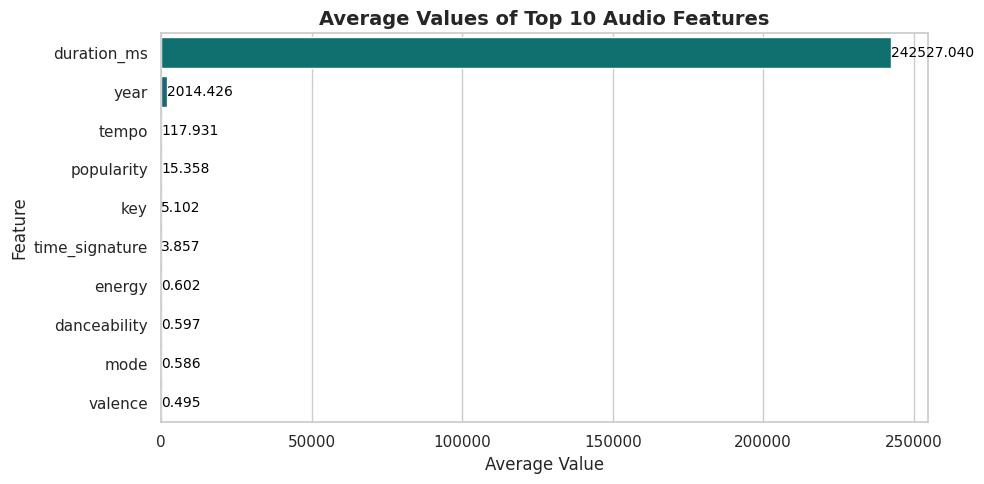

✅ Chart created successfully: /content/spotify_outputs/top10_feature_means_teal_purple.png


In [7]:
# ==============================================
# BAR CHART: Average Values of Top 10 Audio Features
# ==============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Ensure output folder exists
os.makedirs("spotify_outputs", exist_ok=True)

# 2. Load dataset safely
df = pd.read_csv("spotify_tracks.csv", on_bad_lines="skip", engine="python")

# 3. Select only numeric columns
num_df = df.select_dtypes(include=['number'])

# 4. Calculate mean of each numeric feature
feature_means = num_df.mean().sort_values(ascending=False)

# 5. Get top 10 features
top10 = feature_means.head(10)

# 6. Visualization
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")

# Teal–purple gradient palette with 10 colors
colors = sns.color_palette("blend:teal,purple", n_colors=10)

sns.barplot(x=top10.values, y=top10.index, palette=colors)
plt.title("Average Values of Top 10 Audio Features", fontsize=14, weight='bold')
plt.xlabel("Average Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# Add value labels for clarity
for i, v in enumerate(top10.values):
    plt.text(v + 0.01, i, f"{v:.3f}", color='black', va='center', fontsize=10)

plt.tight_layout()

# 7. Save and show
save_path = "spotify_outputs/top10_feature_means_teal_purple.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Chart created successfully: {os.path.abspath(save_path)}")
